#  Product Recommendation System for E-commerce

## Project Overview:
This project aims to develop a product recommendation system that suggests relevant products to users based on image and metadata embeddings. By analyzing the similarities between products, the system provides top recommendations to improve user experience and increase engagement.

### Dataset：Kaggle Fashion Product Images Dataset
https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile, io
from PIL import Image
import requests
from io import BytesIO
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import time
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
images_df = pd.read_csv("fashion-dataset/images.csv")
images_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [3]:
styles_df = pd.read_csv('fashion-dataset/styles.csv', on_bad_lines='skip')
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
styles_df.dtypes

id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
dtype: object

In [5]:
images_df['id'] = images_df['filename'].apply(lambda x: int(x.split('.')[0]))
images_df['id'].dtype

dtype('int64')

In [25]:
final_df = pd.merge(images_df,styles_df,on='id')
final_df.head()

,filename,link,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [26]:
final_df.isna().sum()

filename                0
link                    0
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [27]:
final_df['path'] = final_df['filename'].apply(lambda x: 'fashion-dataset/images/'+x)
final_df.head(3)

,filename,link,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,path
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,fashion-dataset/images/15970.jpg
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,fashion-dataset/images/39386.jpg
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,fashion-dataset/images/59263.jpg


In [28]:
# drop unecessary columns
final_df.drop(columns=['filename','link','year','productDisplayName'],inplace=True)
final_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,Casual,fashion-dataset/images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,Casual,fashion-dataset/images/39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,Casual,fashion-dataset/images/59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,Casual,fashion-dataset/images/21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,Casual,fashion-dataset/images/53759.jpg



# Context:

**Given the computational constraints and the size of the dataset, we have decided to adopt a sampling strategy for our analysis. Specifically, we will use 10% of the data from each subCategory. This approach ensures that the distribution of the data across different categories is maintained while significantly reducing the volume of data to be processed. By doing so, we aim to balance between computational efficiency and maintaining enough data for meaningful insights.**

**The 10% sampling per subCategory allows us to proceed with model training, validation, and recommendation without overwhelming available computational resources, while still retaining representative samples of the product categories for accurate modeling.**

In [29]:
# Sample 10% of data from each masterCategory
sampled_df = final_df.groupby('masterCategory', group_keys=False).apply(lambda x: x.sample(frac=0.1))

# Check the sampled data
print(sampled_df.shape)
print(sampled_df['masterCategory'].value_counts())

(4441, 9)
Apparel           2140
Accessories       1127
Footwear           922
Personal Care      240
Free Items          10
Sporting Goods       2
Name: masterCategory, dtype: int64


In [ ]:
sampled_df.to_csv('sampled_df.csv')

In [30]:
def show_random_images(df, num_images=5, image_column='path'):
    """
    Displays a random selection of images from the dataset.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing image file paths.
    num_images (int): The number of random images to display. Default is 5.
    image_column (str): The column name in the DataFrame that contains the image file paths.
    """
    # Randomly sample the DataFrame
    sampled_df = df.sample(n=num_images)
    
    # Set up a grid to display images
    plt.figure(figsize=(15, 5))
    
    for i, img_path in enumerate(sampled_df[image_column]):
        if os.path.exists(img_path):  # Ensure the image path exists
            img = Image.open(img_path)
            
            # Plot each image in a subplot
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(img_path.split('/')[-1])
            plt.axis('off')  # Hide the axis
        else:
            print(f"Image not found at: {img_path}")
    
    plt.show()

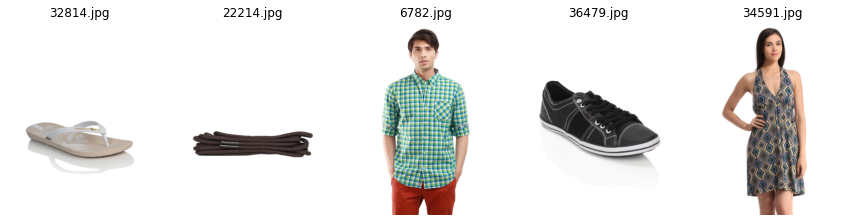

In [32]:
show_random_images(sampled_df, num_images=5, image_column='path')

# EDA

In [43]:
sampled_df.nunique()

id                4441
gender               5
masterCategory       6
subCategory         35
articleType        111
baseColour          42
season               4
usage                7
path              4441
dtype: int64

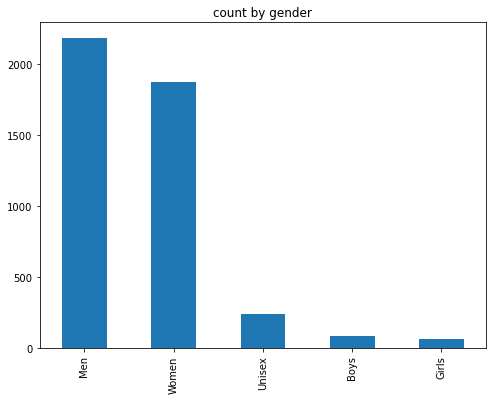

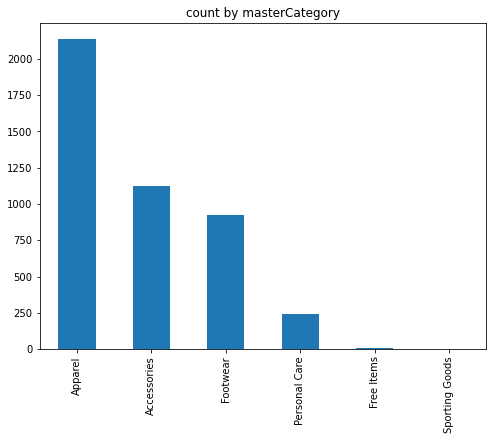

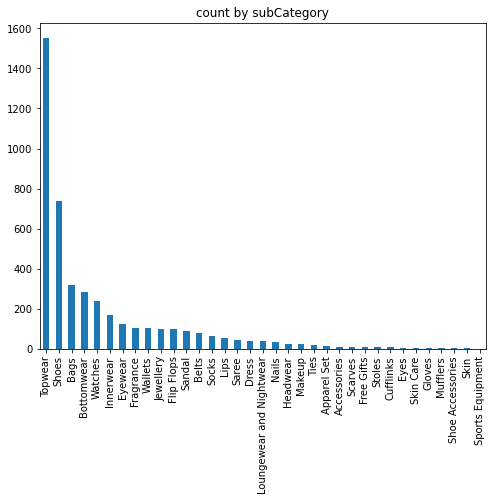

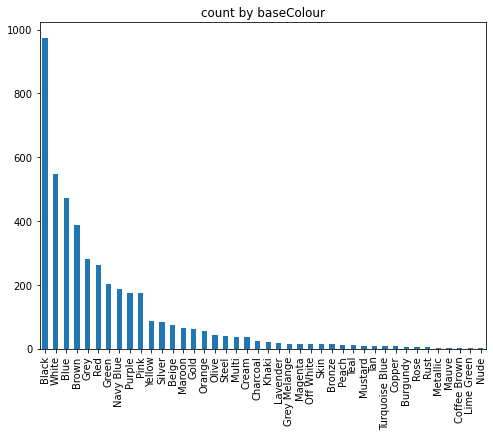

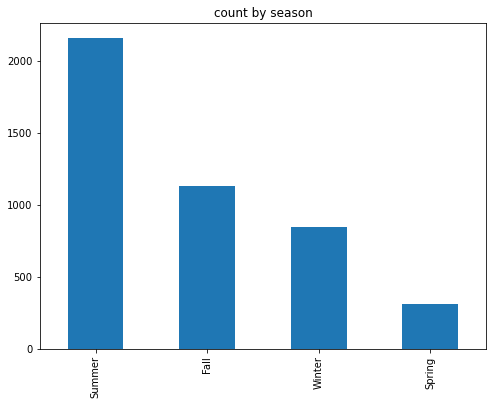

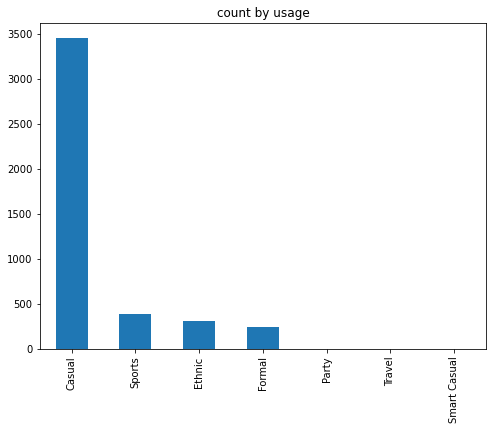

In [35]:
cat = ['gender','masterCategory','subCategory','baseColour','season','usage']
for i in cat:
    plt.figure(figsize=(8,6))
    sampled_df[i].value_counts().plot(kind='bar')
    plt.title(f'count by {i}')
    plt.show()

# Baseline strategy

## Image embedding

In [36]:
# use pretrained resnet50 for feature extraction
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
model.eval()

# Transformation to apply to the images before passing through the model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to get image embeddings
def get_image_embedding(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        embedding = model(img_tensor)
    return embedding.flatten().numpy()


/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# Loop over the dataset and compute image embeddings
image_embeddings = []
for p in tqdm(sampled_df['path']):
    embedding = get_image_embedding(p)
    image_embeddings.append(embedding)

# Convert list to numpy array for easy handling
image_embeddings = np.array(image_embeddings)

100%|██████████| 4441/4441 [19:57<00:00,  3.71it/s]


In [44]:
img_emb = pd.DataFrame(image_embeddings)
img_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.104044,0.591493,0.146628,0.381508,0.390477,0.447301,0.298303,0.145971,0.158393,0.158205,...,0.722535,0.886249,0.413625,0.232296,0.339836,0.300912,0.154202,0.421117,0.302856,0.415082
1,0.709618,0.356734,0.077635,0.462075,0.077227,1.103229,0.463884,0.682481,0.684102,0.106260,...,0.155916,0.117431,0.006015,0.093342,0.311779,0.001067,0.043467,0.205703,0.441505,0.003451
2,0.050910,0.153856,0.534929,0.650562,0.268451,0.176490,0.876497,0.292049,0.129999,0.091818,...,0.585328,0.219330,1.094779,0.317997,0.259780,0.156495,0.347310,0.213121,0.339739,0.185925
3,0.460728,0.997382,0.184008,0.043652,0.079251,0.367052,1.085395,0.314625,1.193967,0.677475,...,0.056352,0.157874,0.050779,0.267342,0.177764,0.111502,0.105540,0.032526,0.961123,0.847384
4,1.120857,1.073111,0.221386,0.165292,0.108933,0.704963,0.200369,0.341509,0.335465,0.289892,...,0.935522,0.315334,0.017178,0.721768,0.234999,0.003269,0.024537,0.695537,0.190853,0.438869


In [45]:
img_emb.to_csv('img_emb.csv')

## Recommendation based on image embeddings

In [77]:
def get_top_k_similar_products(input_image_embedding, img_emb, k):
    """
    Returns the top K similar product indices based on cosine similarity.
    
    Parameters:
    input_image_embedding (numpy array): The embedding of the input image.
    img_emb (pd.DataFrame): DataFrame containing the precomputed image embeddings.
    k (int): Number of similar products to return (default is 10).
    
    Returns:
    top_k_indices (list): List of indices for the top K similar products.
    """
    similarities = cosine_similarity([input_image_embedding], img_emb)[0]
    top_n_indices = similarities.argsort()[-(k+1):-1][::-1]  # Get top N similar indices apart from itself
    return top_n_indices

In [82]:
def plot_top_k_similar_products(top_k_indices, sampled_df):
    """
    Plot the top K similar product images along with their product IDs.
    
    Parameters:
    top_k_indices (list): List of indices of the top K similar products.
    sampled_df (pd.DataFrame): DataFrame containing product IDs and image paths.
    """
    plt.figure(figsize=(15, 5))  # Set up the figure size
    for i, idx in enumerate(top_k_indices):
        img_path = sampled_df.iloc[idx]['path']  # Get the image path from sampled_df
        product_id = sampled_df.iloc[idx]['id']  # Get the product ID from sampled_df
        
        # Open and display the image
        img = Image.open(img_path)
        plt.subplot(1, len(top_k_indices), i + 1)
        plt.imshow(img)
        plt.title(product_id)  # Set the title to the product ID
        plt.axis('off')  # Hide the axis for a cleaner look
    
    plt.show()


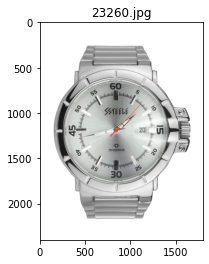

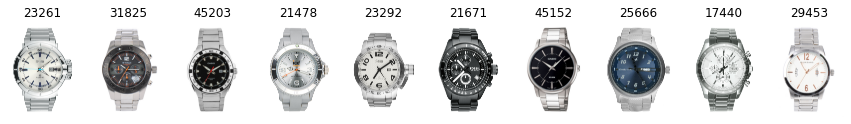

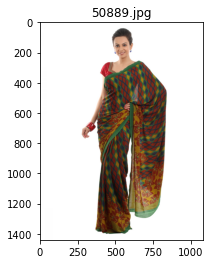

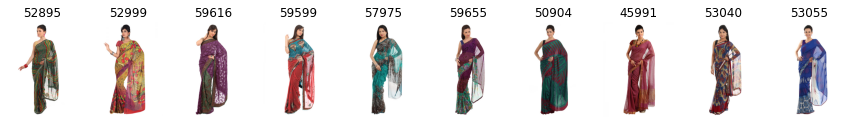

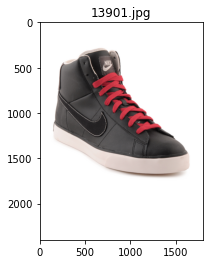

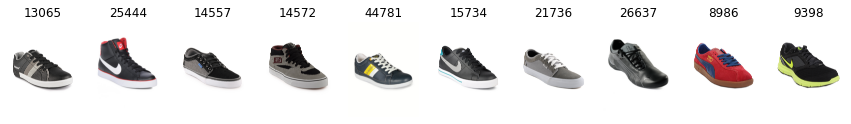

In [92]:
# Randomly select 3 items for recommendation 

for i in sampled_df['path'].sample(3).values:
    input_embedding = get_image_embedding(i)
    # Get the top 10 most similar products
    top_10_indices = get_top_k_similar_products(input_embedding, image_embeddings, k=10)
    
    img = Image.open(i)
    plt.imshow(img)
    plt.title(i.split('/')[-1])
    plot_top_k_similar_products(top_10_indices, sampled_df)

## Visualization

In [95]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_emb)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 12.859822750091553 seconds


In [96]:
sampled_df['tsne-2d-one'] = tsne_results[:,0]
sampled_df['tsne-2d-two'] = tsne_results[:,1]

In [97]:
sampled_df.head(3)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,path,tsne-2d-one,tsne-2d-two
1606,32368,Men,Accessories,Watches,Watches,Black,Winter,Casual,fashion-dataset/images/32368.jpg,-9.109500,-10.756548
43226,33605,Women,Accessories,Wallets,Wallets,Blue,Summer,Casual,fashion-dataset/images/33605.jpg,-1.914404,-3.910608
884,19911,Unisex,Accessories,Bags,Messenger Bag,Grey,Winter,Casual,fashion-dataset/images/19911.jpg,-8.251449,-1.362716


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

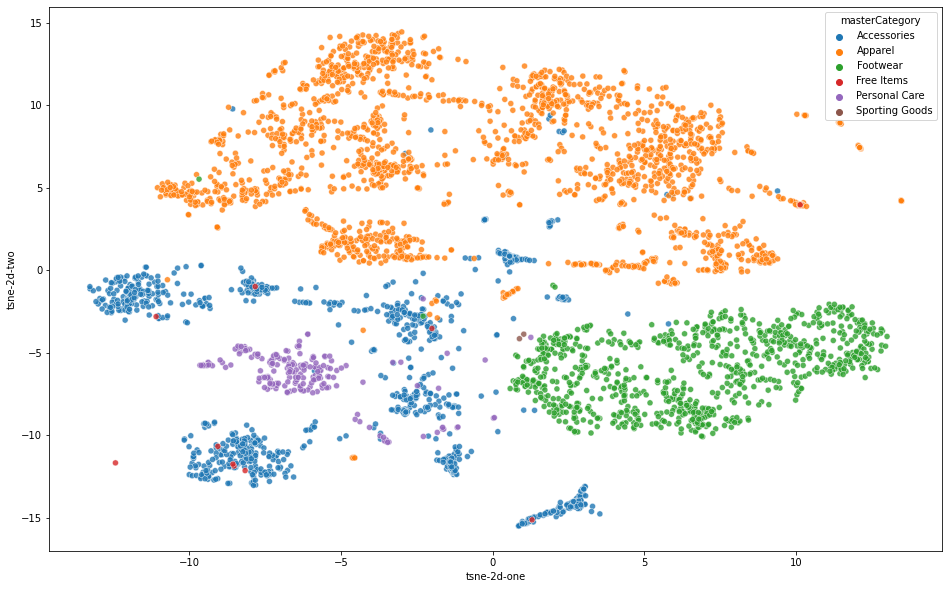

In [99]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=sampled_df,
                legend="full",
                alpha=0.8)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

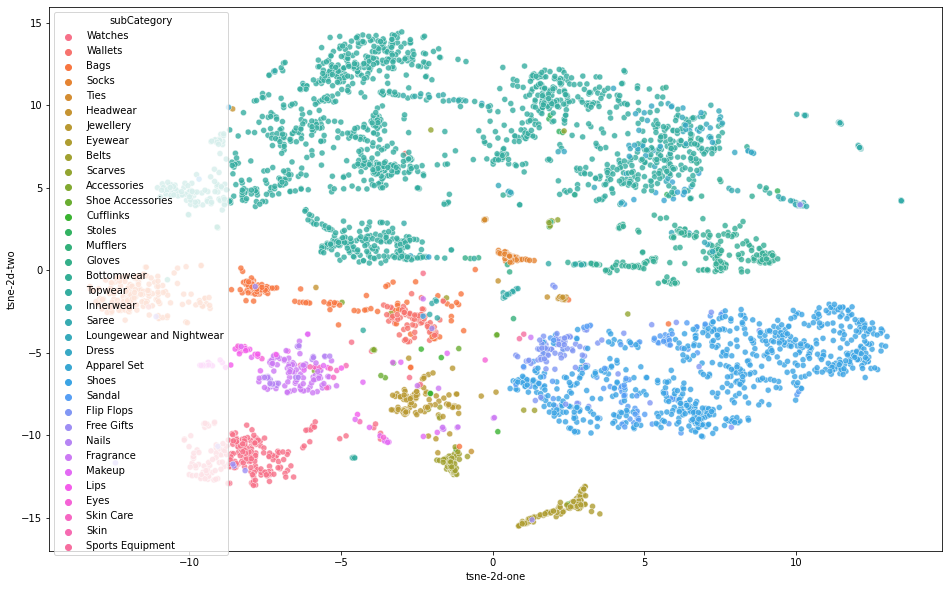

In [100]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=sampled_df,
                legend="full",
                alpha=0.8)

# Strategy 2: Combine metadata

## Metadata Encoding

In [133]:
# encode categorical variables

cat = ['gender','masterCategory','subCategory','baseColour','season','usage']
encoder = OneHotEncoder()
encoded_metadata = encoder.fit_transform(sampled_df[cat])

In [134]:
combined_features = np.concatenate([image_embeddings, encoded_metadata.toarray()], axis=1)

## Recommendation

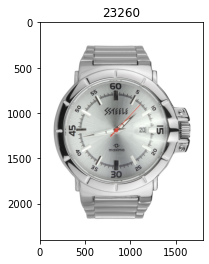

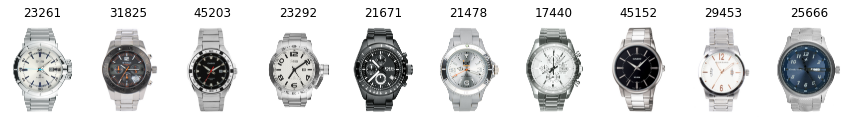

In [135]:
sample1 = sampled_df[sampled_df['id'] == 23260]
img_embedding1 = get_image_embedding(sample1['path'].values[0])
meta_embedding1 = encoder.transform(sample1[cat])
com_embedding1 = np.concatenate([img_embedding1, meta_embedding1.toarray().flatten()])
top_10_indices = get_top_k_similar_products(com_embedding1, combined_features, k=10)
    
img = Image.open(sample1['path'].values[0])
plt.imshow(img)
plt.title(sample1['id'].values[0])
plot_top_k_similar_products(top_10_indices, sampled_df)

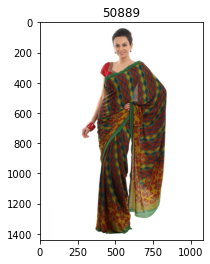

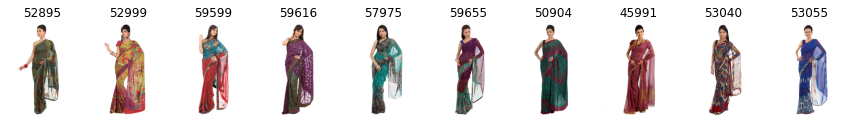

In [130]:
sample2 = sampled_df[sampled_df['id'] == 50889]
img_embedding2 = get_image_embedding(sample2['path'].values[0])
meta_embedding2 = encoder.transform(sample2[cat])
com_embedding2 = np.concatenate([img_embedding2, meta_embedding2.toarray().flatten()])
top_10_indices2 = get_top_k_similar_products(com_embedding2, combined_features, k=10)
    
img = Image.open(sample2['path'].values[0])
plt.imshow(img)
plt.title(sample2['id'].values[0])
plot_top_k_similar_products(top_10_indices2, sampled_df)

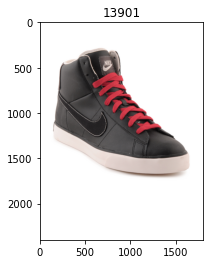

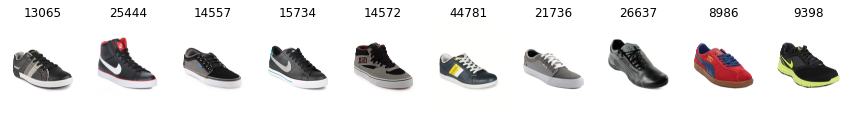

In [131]:
sample3 = sampled_df[sampled_df['id'] == 13901]
img_embedding3 = get_image_embedding(sample3['path'].values[0])
meta_embedding3 = encoder.transform(sample3[cat])
com_embedding3 = np.concatenate([img_embedding3, meta_embedding3.toarray().flatten()])
top_10_indices3 = get_top_k_similar_products(com_embedding3, combined_features, k=10)
    
img = Image.open(sample3['path'].values[0])
plt.imshow(img)
plt.title(sample3['id'].values[0])
plot_top_k_similar_products(top_10_indices3, sampled_df)

### Comparison:

When comparing two recommendation approaches: one based purely on image embeddings and the other using a combination of image embeddings and metadata (such as categorical features like gender, masterCategory, etc.).

The key findings are as follows:

* The top 10 recommended products from both approaches are largely the same across both methods. This indicates that the visual features extracted from the images are robust and highly predictive of product similarity.
* However, the order of the recommended products within the top 10 differs slightly between the two methods. The inclusion of metadata leads to subtle changes in the ranking, likely due to the added influence of the categorical information, which adjusts the similarity scores.

Overall, while the core set of recommendations remains stable, the combination of image embeddings with metadata provides a more nuanced ranking, fine-tuning the order based on non-visual attributes. This suggests that incorporating metadata can help refine the recommendation results by taking into account additional product attributes, though the overall similarity remains driven by visual features.